# Pipeline to compute attractors/phenotype distribution differences between resistant and sensitive patients and gene differently expression analysis

In [ ]:
import pandas as pd
from scipy import stats
from scipy.stats import spearmanr


from functions.analysis import downstream_analysis
# from functions.analysis_utils.MaBoSS_simulation.maboss_phenotype_patient import compute_phenotype_table, collect_group_data,
from functions.analysis_utils.results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from functions.analysis_utils.genes_intervention.pers_interventions import tailor_bnd_genes_intervention
from functions.analysis_utils.stats.stats_proba import compute_mannwhitneyu_test_means


from functions.analysis_utils.results_MaBoSS_visualization.create_phenotypes_patients_table import (
    vizualise_table_phenotype_condition, plot_side_by_side_heatmaps
)

from functions.analysis_utils.gene_enrichment.genes_signature import create_results_gene_enrichment

from functions.analysis_utils.results_MaBoSS_visualization.patients_ids_phenotype_table import create_combined_table_patients

from functions.analysis_utils.stats.stats_proba import compute_power_calculation





from functions.validation_utils.validation_Breast import (
    correlate_boolean_predictions_with_gene_signatures, survival_analysis_comparison
)


good results if do not simulate the drug target KO ??
check again what happeens if drug target not blocked

### User data parameters

In [2]:
# models inputs
patients_categ = ['resistant', 'sensitive', 'healthy']

inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'SPOP', 'Carcinogen']

# models outputs
phenotype_interest = ["Proliferation","Invasion","DNA_Repair","Apoptosis"]


# type_model_folder_name = 'genes_models_cnv_genes'
type_model = 'genes_models'




drug_interest = 'AZD7762' 
drug_targets = ['CHK1_2']

# tissue_interest = 'HAEMATOPOIETIC AND LYMPHOID'


subdir = f"{'_'.join(drug_targets)}_target_block"




#blood tissue
# folder_models = f"analysis/{drug_interest}/{folder_name}/{subdir}/models"
# folder_results = f"analysis/{drug_interest}/{folder_name}/{subdir}"


annotations_models = pd.read_csv('data/model_list_20250407.csv')
# Montagud analysis - Growth factors (EGF and FGF), Nutrients and Androgen ON
# # Montagud analysis - Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia
# list_active_inputs =  [['EGF', 'FGF', 'NUTRIENTS', 'ANDROGEN'], 
#                         ['CARCINOGEN', 'ANDROGEN', 'TNF', 'ACIDOSIS', 'HYPOXIA']
#                         ]

continuous_variable = 'genes'
discrete_variable = 'mutations'

folder_name = f'{discrete_variable}_{continuous_variable}'


folder_models = f"analysis/{drug_interest}/{folder_name}/{subdir}/models"
folder_results = f"analysis/{drug_interest}/{folder_name}/{subdir}"



### Loading the datasets

In [ ]:
# Load top patient IDs from files saved in pipeline 1


with open(f"analysis/{drug_interest}/top_resistant_ids.txt") as f:
    top_resistant_ids = [line.strip() for line in f if line.strip()]

with open(f"analysis/{drug_interest}/top_sensitive_ids.txt") as f:
    top_sensitive_ids = [line.strip() for line in f if line.strip()]


with open(f"analysis/{drug_interest}/top_healthy_ids.txt") as f:
    top_healthy_ids = [line.strip() for line in f if line.strip()]

patients_ids = top_resistant_ids + top_sensitive_ids + top_healthy_ids

### Compute attractors/ phenotypes distribution and differential genes expression

In [4]:
# simulate growth factors (EGF and FGF), Nutrients and Androgen ON (cf Montagud paper)
# #  simulate with Carcinogen, Androgen, TNFalpha, Acidosis, and Hypoxia ON. (cf Montagud paper)
# downstream_analysis(folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, list_active_inputs = list_active_inputs)

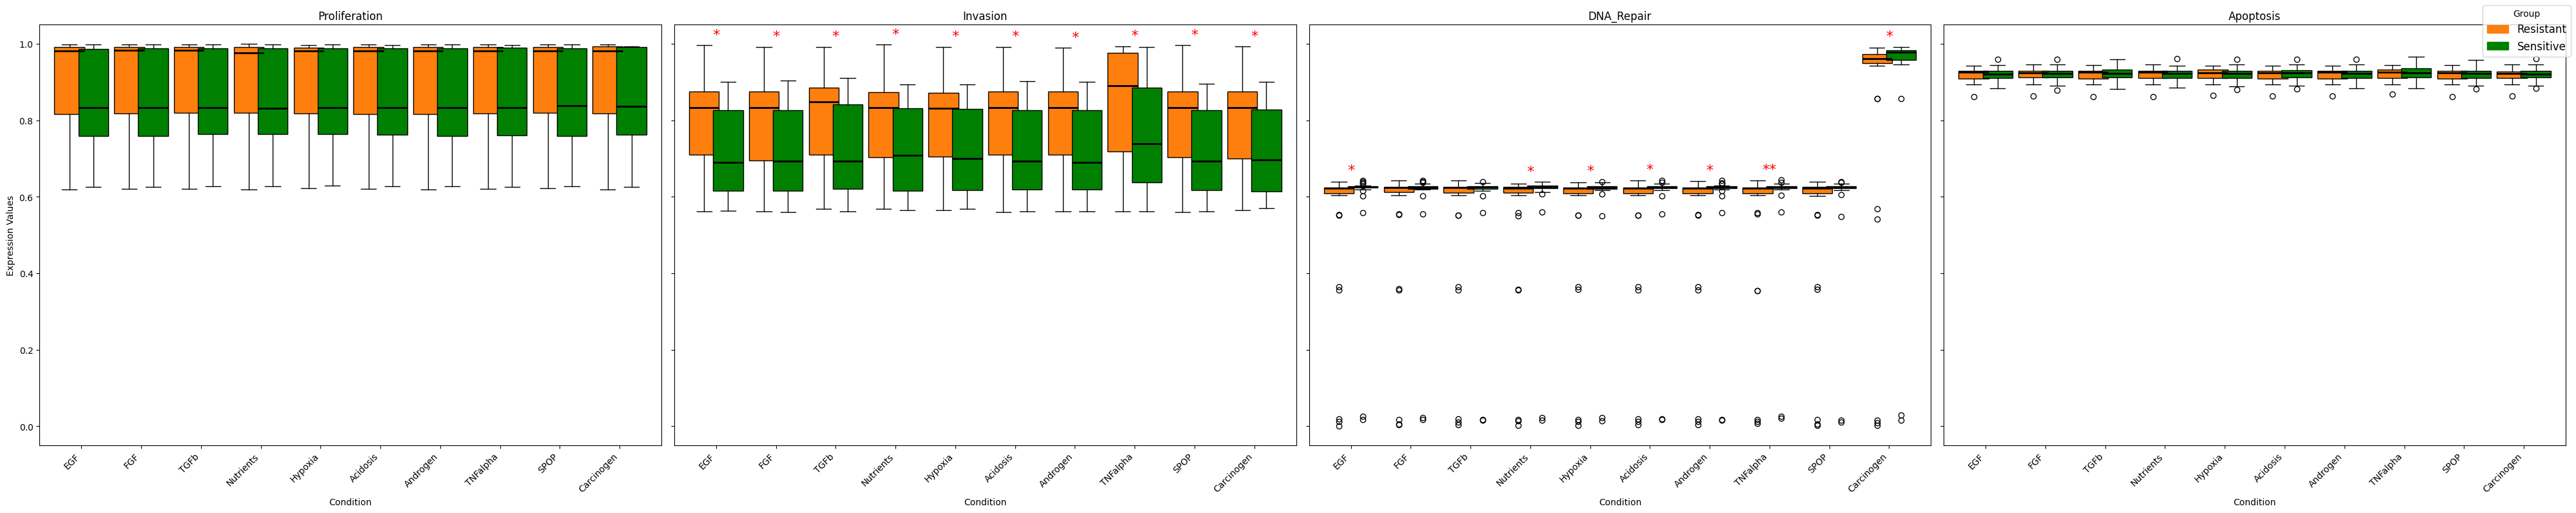

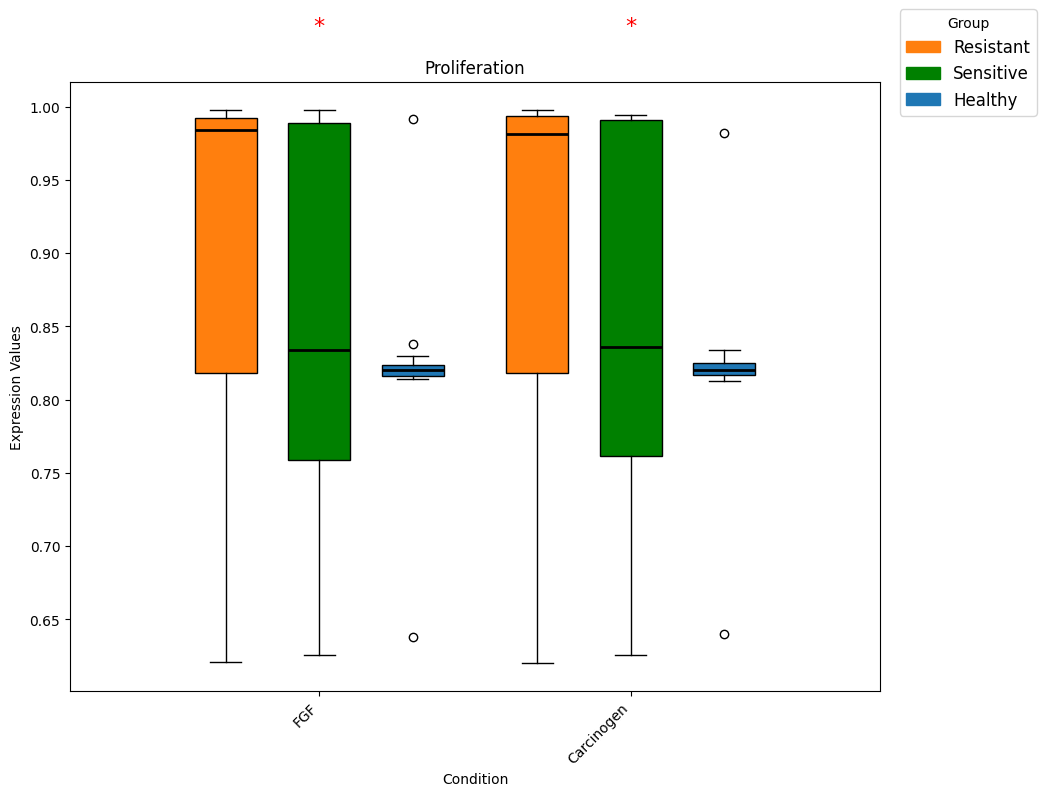

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/MaBoSS_simulation/maboss_phenotype_patient.py:262: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patient_mean.loc[condition][phenotype] = mean
/Users/romane/repos/icr/Attr

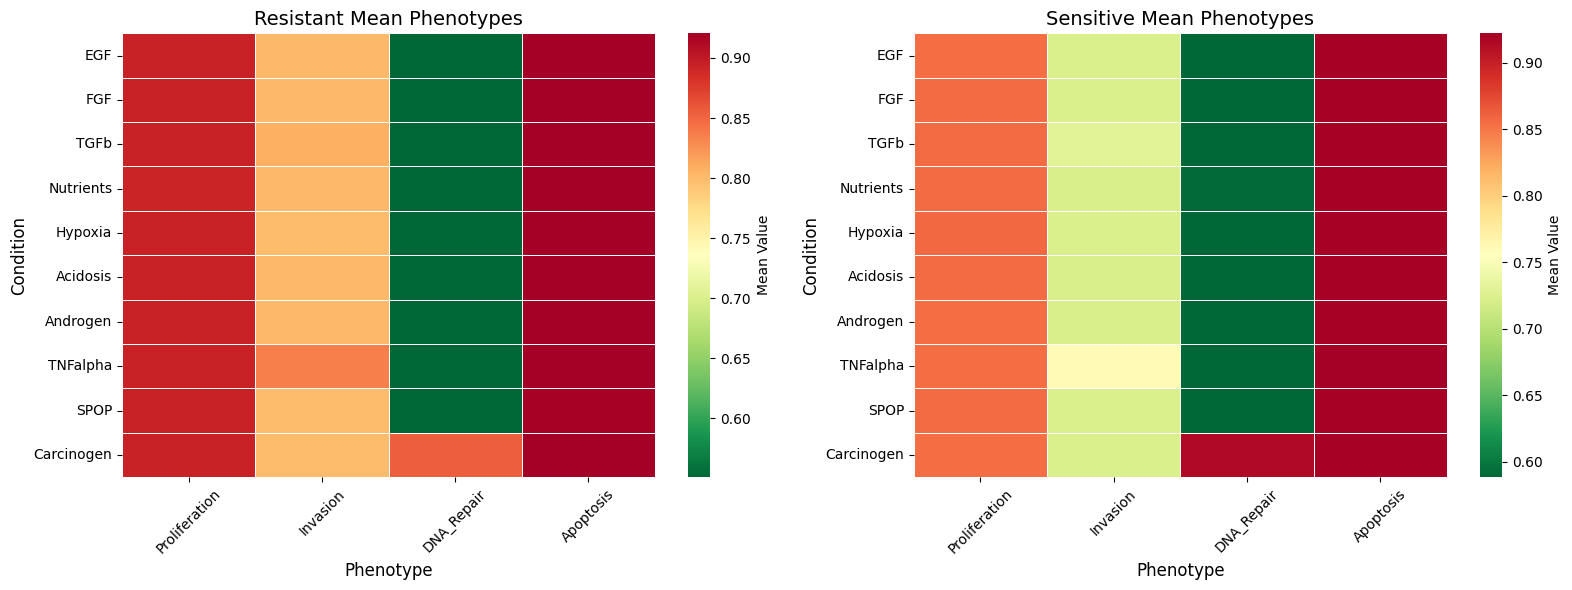

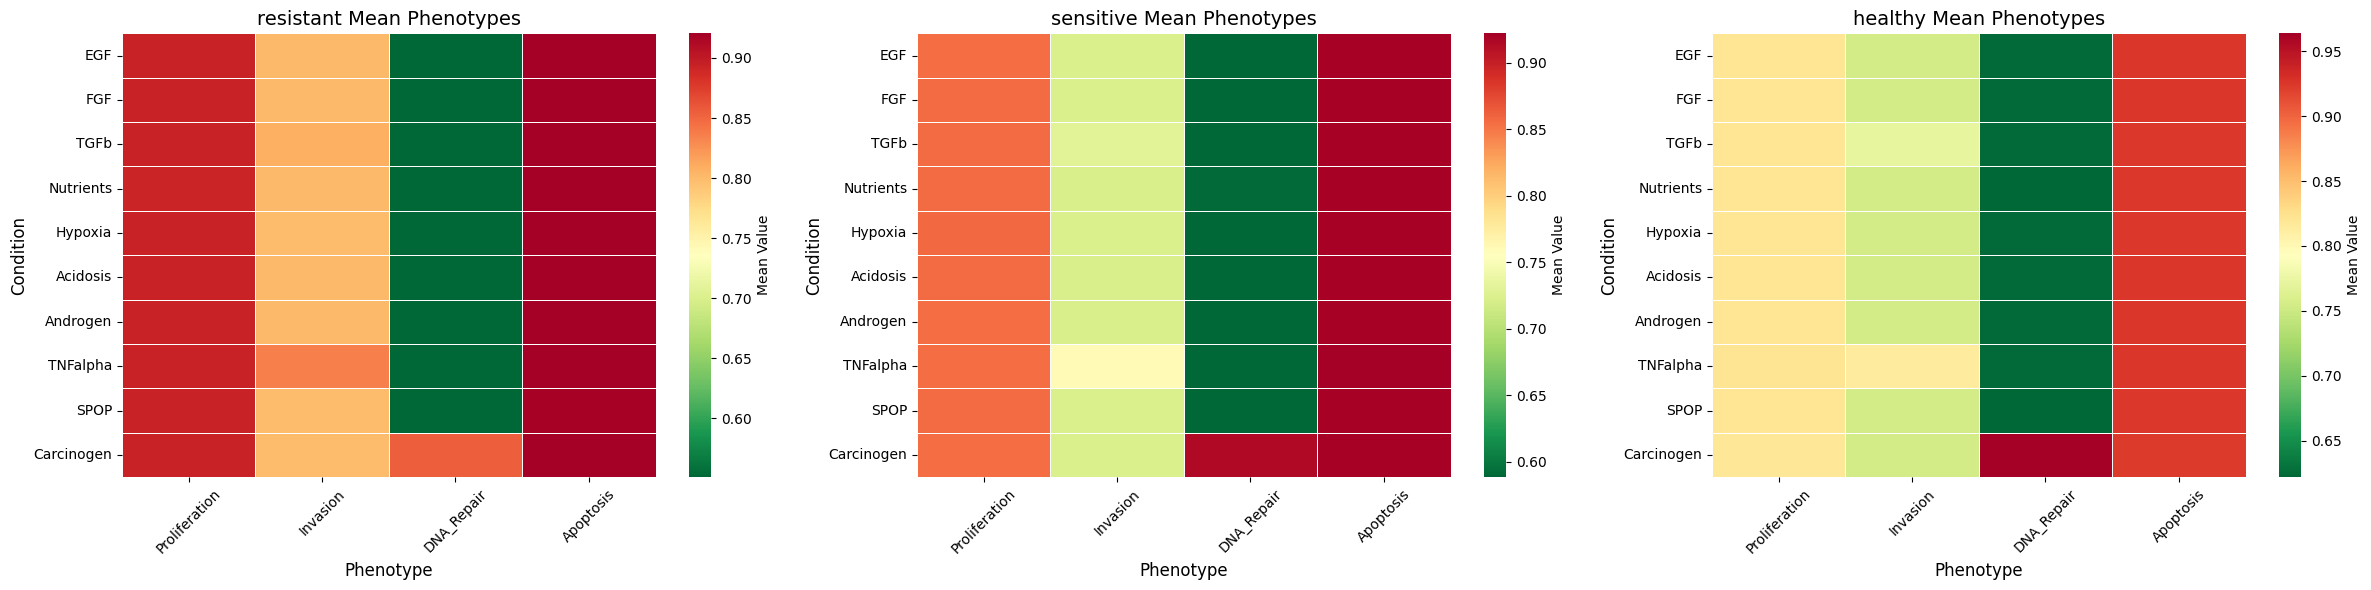

['SIDM00758', 'SIDM00770', 'SIDM00217', 'SIDM00772', 'SIDM01242', 'SIDM00835', 'SIDM00574', 'SIDM00415', 'SIDM00920', 'SIDM00882', 'SIDM00881', 'SIDM00700', 'SIDM00879', 'SIDM00892', 'SIDM00448', 'SIDM01186', 'SIDM00097', 'SIDM01175', 'SIDM00653', 'SIDM00282', 'SIDM00719', 'SIDM01002', 'SIDM00293', 'SIDM00735', 'SIDM00292', 'SIDM00319', 'SIDM00737', 'SIDM00194', 'SIDM00547', 'SIDM00235', 'SIDM00963', 'SIDM00340', 'SIDM00633', 'SIDM00971', 'SIDM01107', 'SIDM00604', 'SIDM01095', 'SIDM00412', 'SIDM00406', 'SIDM00567', 'SIDM00407', 'SIDM01057', 'SIDM00388', 'SIDM00798', 'SIDM00428', 'SIDM00561', 'SIDM00211', 'SIDM00576', 'SIDM00459', 'SIDM01009', 'SIDM00277', 'SIDM01023', 'SIDM00264', 'SIDM00449', 'SIDM00875', 'SIDM01015', 'SIDM01003', 'SIDM01017', 'SIDM00657', 'SIDM01005', 'SIDM01010', 'SIDM01038', 'SIDM01076', 'SIDM01248', 'SIDM00544', 'SIDM00949', 'SIDM00421', 'SIDM00233', 'SIDM00740', 'SIDM00437']
Saved final phenotype table to: analysis/AZD7762/mutations_genes/CHK1_2_target_block/resu

/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/gene_enrichment/genes_signature.py:132: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_normal_group_2 = stats.shapiro(group_sensitive)
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/gene_enrichment/genes_signature.py:141: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value = stats.mannwhitneyu(
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/gene_enrichment/genes_signature.py:132: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_normal_group_2 = stats.shapiro(group_sensitive)
/Users/romane/repos/icr/Attractor-Resistance/functions/analysis_utils/gene_enrichment/ge

In [5]:
# for each input ON at a time 
downstream_analysis(folder_name, subdir,folder_results,folder_models, drug_interest, top_resistant_ids, top_sensitive_ids, top_healthy_ids, patients_categ, inputs_list, phenotype_interest, annotations_models, list_active_inputs = None)

### Gene signature correlation

In [ ]:


hallmark = 'Epithelial Mesenchymal Transition'
phenotype = 'Invasion'

proba_phenotype = pd.read_csv(f'analysis/{drug_interest}/mutations_genes_normalize/CHK1_2_target_block/results/sensitive_resistant_results/patients_phenot_table.csv', index_col=0)
rna_seq_data = pd.read_csv('data/cellmodel_data/rnaseq_merged_20250117/rnaseq_merged_20250117.csv')



healthy_ids = pd.read_csv(f'analysis/{drug_interest}/top_healthy_ids.txt', header=None)
resistant_ids = pd.read_csv(f'analysis/{drug_interest}/top_resistant_ids.txt', header=None)
sensitive_ids = pd.read_csv(f'analysis/{drug_interest}/top_sensitive_ids.txt', header=None)

healthy_ids_list = healthy_ids[0].tolist()
resistant_ids_list = resistant_ids[0].tolist()
sensitive_ids_list = sensitive_ids[0].tolist()

patients_ids = healthy_ids_list + resistant_ids_list + sensitive_ids_list



results_corr_df, correlation_data = correlate_boolean_predictions_with_gene_signatures(proba_phenotype, hallmark, phenotype, rna_seq_data, patients_ids)


## Correlation Invasion probability and tumor status (metastasis, tumour, normal)

In [ ]:
annotations = pd.read_csv('data/cellmodel_data/model_list_20250423.csv')

annotations.dropna(axis=1, how='all', inplace=True)

annotations_filtered = annotations[['model_id', 'tissue_status']]
annotations_filtered = annotations_filtered[annotations_filtered['model_id'].isin(patients_ids)]


annotations_filtered['tissue_status_numeric'] = annotations_filtered['tissue_status'].map({
    'Normal': 0,
    'Tumour': 1,
    'Metastasis': 2
})

proba_phenotype_filtered = proba_phenotype[proba_phenotype.index.isin(patients_ids)]
proba_phenotype_filtered = proba_phenotype_filtered.reset_index()
proba_phenotype_filtered = proba_phenotype_filtered.rename(columns={'index': 'model_id'})

col_invasion = [col for col in proba_phenotype_filtered.columns if 'Invasion' in col]
print(f"Invasion columns: {col_invasion}")

proba_phenotype_filtered_invasion = proba_phenotype_filtered[['model_id'] + col_invasion]


df_merged = proba_phenotype_filtered_invasion.merge(annotations_filtered, left_on='model_id', right_on='model_id')

df_results = pd.DataFrame(index=col_invasion, columns=['spearman_corr','spearman_p'])

for col_inv in col_invasion:
    print(col_inv)
    spearman_corr, spearman_p = spearmanr(df_merged[col_inv], df_merged['tissue_status_numeric'])
    df_results.loc[col_inv, 'spearman_corr'] = spearman_corr
    df_results.loc[col_inv, 'spearman_p'] = spearman_p  # Fixed: was spearman_corr, should be spearman_p
df_results


In [ ]:
annotations_models_test = annotations_models[annotations_models['model_id'].isin(patients_ids)]

annotations_models_test = annotations_models_test[['model_id', 'tumour_grade', 
                                                   'venous_invasion_present', 
                                                   'lymphatic_invasion_present', 
                                                   'perineural_invasion_present']]

# annotations_models_test = annotations_models_test[['model_id', 'tumour_grade',
#                                                    'metastasis_at_diagnosis']]

### Downstream analysis - test CTNNB1 gene 

In [ ]:
# compute the mean of the genes identified in the previous differential expression genes analysis
# genes_diff_expressed = pd.read_csv('analysis/Pictilisib/genes_models/PI3K_target_block/results/genes_diff_expressed/significant_genes_EGF_ON_Invasion.csv', index_col=0)

In [ ]:


# # Find the integer position of the index label 'VHL'
# cutoff_position = genes_diff_expressed.index.get_loc('YWHAZ')

# # Slice the DataFrame up to that position
# genes_diff_expressed_table = genes_diff_expressed.iloc[:cutoff_position + 1]

# # # Optional: reset index if needed
# # genes_diff_expressed_table.reset_index(inplace=True)


In [ ]:
# values_ctnnb1_healthy = list(rna_seq_data[
#     (rna_seq_data['model_id'].isin(top_healthy_ids)) &
#     (rna_seq_data['gene_symbol'] == 'CTNNB1')
# ]['rsem_tpm'])


# values_ctnnb1_resistant = list(rna_seq_data[
#     (rna_seq_data['model_id'].isin(top_resistant_ids)) &
#     (rna_seq_data['gene_symbol'] == 'CTNNB1')
# ]['rsem_tpm'])

# values_ctnnb1_sensitive = list(rna_seq_data[
#     (rna_seq_data['model_id'].isin(top_sensitive_ids)) &
#     (rna_seq_data['gene_symbol'] == 'CTNNB1')
# ]['rsem_tpm'])

In [ ]:
# # kruskal test
# result = stats.kruskal(values_ctnnb1_healthy, values_ctnnb1_resistant, values_ctnnb1_sensitive)
# result

KruskalResult(statistic=np.float64(9.793832980346622), pvalue=np.float64(0.007469580120591721))